In [2]:
from graphix.random_objects import rand_circuit, Circuit
import graphix.command
import numpy as np

nqubits = 2
depth = 1
fx_rng = np.random.default_rng()
circuit = rand_circuit(nqubits, depth, fx_rng)

circuit = Circuit(2)
# circuit.h(0)
# circuit.h(0)
circuit.cnot(0,1)
# circuit.h(1)
circuit.rz(0,np.pi/4)

pattern = circuit.transpile().pattern
pattern.standardize()

classical_output = pattern.output_nodes
print(classical_output)
# don't forget to add in the output nodes that are not initially measured!
for onode in classical_output:
    pattern.add(graphix.command.M(node=onode))

[5, 3]


In [3]:
from veriphix.client import Client, Secrets
from graphix.states import BasicStates
states = [BasicStates.PLUS for _ in pattern.input_nodes]
secrets = Secrets(r=True, a=True, theta=True)
client = Client(pattern=pattern, secrets=secrets, input_state=states)

test_runs = client.create_test_runs()
number_of_traps = sum([len(run.trap_qubits)
                    for run in test_runs])
# should be = len(client.graph[0])
n_nodes = len(client.graph[0])
print(f"The graph of the pattern has {n_nodes} nodes.")
print(f"There are {number_of_traps} traps in total.")

The graph of the pattern has 6 nodes.
There are 6 traps in total.


In [32]:
from noise_model import VBQCNoiseModel
from graphix.sim.density_matrix import DensityMatrixBackend
from graphix.sim.statevec import StatevectorBackend
backend = DensityMatrixBackend()
# backend = StatevectorBackend()

In [35]:
print(f"There are {number_of_traps} traps in total.")
for p in [0, 0.01,0.1, 0.5, 0.7, 1]:
    noise = VBQCNoiseModel(
        prepare_error_prob=p, # 0.7
        x_error_prob=p,
        z_error_prob=p,
        entanglement_error_prob=p,
        measure_channel_prob=p,
        measure_error_prob=p,
    )
    N = 100
    n=0
    for run in test_runs:
        for i in range(N):
            client.refresh_randomness()
            trap_outcomes = client.delegate_test_run(run=run, backend=backend, noise_model=noise)
            # A trap is failed if the sum of the outcomes is 1
            n_failed_traps = sum(trap_outcomes)
            n += n_failed_traps
    print(f"Noise model with p={p}, {n}/{number_of_traps*N} traps failed.")
        

There are 6 traps in total.
Noise model with p=0, 0/600 traps failed.
Noise model with p=0.01, 21/600 traps failed.
Noise model with p=0.1, 209/600 traps failed.
Noise model with p=0.5, 320/600 traps failed.
Noise model with p=0.7, 316/600 traps failed.
Noise model with p=1, 285/600 traps failed.


It becomes also relevant to write the number of occurrence per output bitstring (length 2) for a normal delegation. Again trying 100 times.

In [ ]:
print(f"There are {number_of_traps} traps in total.")
for p in [0, 0.01,0.1, 0.5, 0.7, 1]:
    noise = VBQCNoiseModel(
        prepare_error_prob=p, # 0.7
        x_error_prob=p,
        z_error_prob=p,
        entanglement_error_prob=p,
        measure_channel_prob=p,
        measure_error_prob=p,
    )
    N = 100
    n=0
    for i in range(N):
        # Delegate each test run N times
        for run in test_runs:
            client.refresh_randomness()
            trap_outcomes = client.delegate_test_run(run=run, backend=backend, noise_model=noise)
            # A trap is failed if the sum of the outcomes is 1
            n_failed_traps = sum(trap_outcomes)
            n += n_failed_traps
        

    print(f"Noise model with p={p}, {n}/{number_of_traps*N} traps failed.")
        

There are 6 traps in total.
Noise model with p=0, 0/600 traps failed.
Noise model with p=0.01, 21/600 traps failed.
Noise model with p=0.1, 209/600 traps failed.
Noise model with p=0.5, 320/600 traps failed.
Noise model with p=0.7, 316/600 traps failed.
Noise model with p=1, 285/600 traps failed.


## Concrete VBQC example

In [9]:
import random as rd
from noise_model import VBQCNoiseModel
from graphix.sim.density_matrix import DensityMatrixBackend
from graphix.sim.statevec import StatevectorBackend
import matplotlib.pyplot as plt
import random as rd
import numpy as np
from random import randint

Attempt with noise model p=0
Iterating 100 times with 100 computation rounds and 0 trap rounds.
Attempt with noise model p=1
Iterating 100 times with 100 computation rounds and 0 trap rounds.


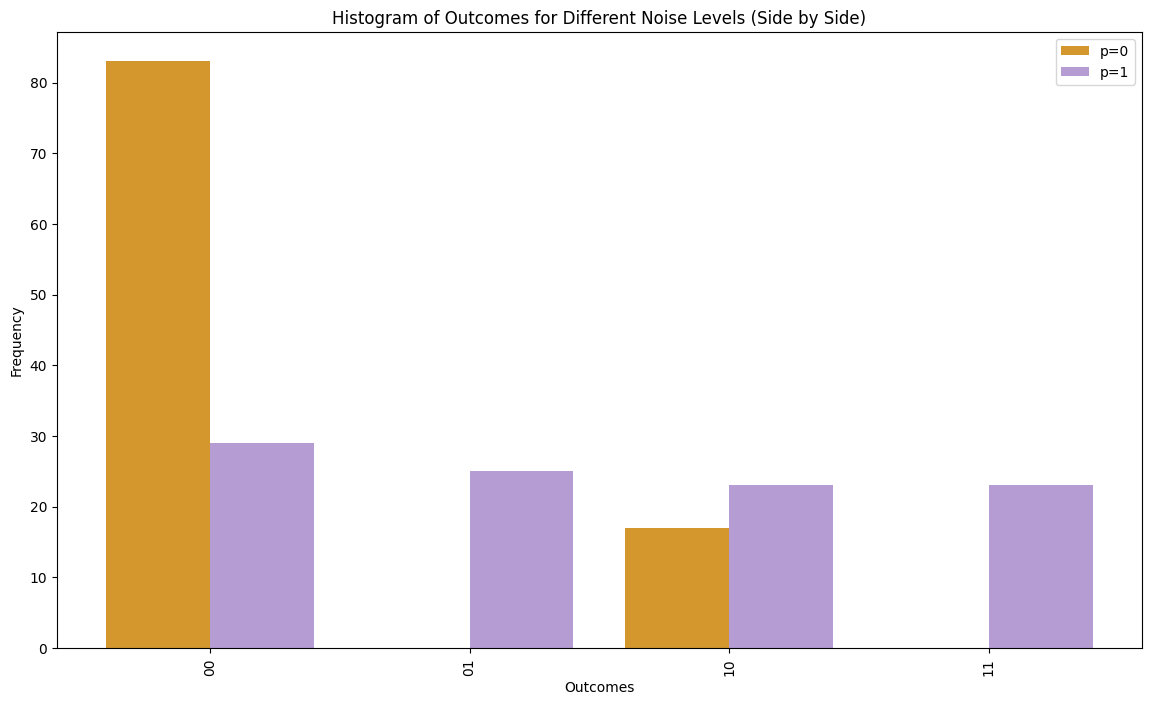

In [10]:
# Function to generate random colors
def random_color():
    return f'#{randint(0, 255):02X}{randint(0, 255):02X}{randint(0, 255):02X}'

# Trappified scheme parameters
d = 100
t = 0
N = d + t

# Re-setting the backend
backend = DensityMatrixBackend()

# Store data for each value of p
all_histograms = {}

# Example of multiple p values for generalization
p_values = [0, 1]

for p in p_values:
    noise = VBQCNoiseModel(
        prepare_error_prob=p,
        x_error_prob=p,
        z_error_prob=p,
        entanglement_error_prob=p,
        measure_channel_prob=p,
        measure_error_prob=p,
    )
    print(f"Attempt with noise model p={p}")
    print(f"Iterating {N} times with {d} computation rounds and {t} trap rounds.")
    outcomes_histogram = dict()

    for _ in range(N):
        i = rd.choice(range(N))
        if i < d:
            # Computation round
            client.refresh_randomness()
            client.delegate_pattern(backend=backend, noise_model=noise)
            computation_outcome = ""
            for onode in classical_output:
                computation_outcome += str(client.results[onode])
            if computation_outcome not in outcomes_histogram:
                outcomes_histogram[computation_outcome] = 1
            else:
                outcomes_histogram[computation_outcome] += 1
        else:
            # Test round
            pass

    all_histograms[p] = outcomes_histogram

# Combine all unique outcomes from all histograms
all_outcomes = sorted(set().union(*[hist.keys() for hist in all_histograms.values()]))

# Plotting side-by-side bars with random colors
x = np.arange(len(all_outcomes))  # X positions for outcomes
bar_width = 0.8 / len(p_values)  # Dynamic bar width based on the number of p values

plt.figure(figsize=(14, 8))

for idx, (p, histogram) in enumerate(all_histograms.items()):
    frequencies = [histogram.get(outcome, 0) for outcome in all_outcomes]
    color = random_color()  # Generate a random color for each p
    plt.bar(x + idx * bar_width, frequencies, bar_width, color=color, label=f'p={p}')

plt.xlabel('Outcomes')
plt.ylabel('Frequency')
plt.title('Histogram of Outcomes for Different Noise Levels (Side by Side)')
plt.xticks(x + bar_width * (len(p_values) - 1) / 2, all_outcomes, rotation=90)
plt.legend()
plt.show()
